In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane, PatientRecord

In [2]:
data_dir = os.path.join('data','mri-datasets','first-20-testset','dataset_3channel')
tumour_data_dir = os.path.join(data_dir, 'tumour')
healthy_data_dir = os.path.join(data_dir, 'healthy')
try:
    os.mkdir(data_dir)
except FileExistsError:
    print('Directory exists')
try:
    os.mkdir(tumour_data_dir)
except FileExistsError:
    print('Directory exists')
try:
    os.mkdir(healthy_data_dir)
except FileExistsError:
    print('Directory exists')

Directory exists
Directory exists
Directory exists


In [3]:
for patient in range(1,21):

    T1_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_T1.nii.gz',
        sequence=ScanType.T1
    )
    T1CE_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_T1GD.nii.gz',
        sequence=ScanType.T1CE
    )
    T2_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_T2.nii.gz',
        sequence=ScanType.T2
    )
    segmentation = TumourSegmentation(
        filename=f'data/mri-datasets/first-20-testset/automated_segm/UPENN-GBM-{patient:05}_11_automated_approx_segm.nii.gz',
        )

    patient_data = PatientRecord()
    patient_data.add_scan_data(T1_scan)
    patient_data.add_scan_data(T1CE_scan)
    patient_data.add_scan_data(T2_scan)
    patient_data.add_segmentation(segmentation)

    patient_data.save_multi_channel_png(os.path.join(data_dir, f'UPENN-GBM-{patient:05}_11_3_seq'), [ScanType.T2,ScanType.T1CE,ScanType.T1])

In [4]:
data_list = []
for auto_seg in glob.glob('data/mri-datasets/first-20-testset/automated_segm/UPENN-GBM-*_11_automated_approx_segm.nii.gz'):
    patient = auto_seg.removeprefix('data/mri-datasets/first-20-testset/automated_segm/UPENN-GBM-')[:5]
    segmentation = TumourSegmentation(auto_seg)
    for idx, slice in enumerate(segmentation.iterate_slices()):
        data_list.append([patient, idx, 1 if 1 in slice.slice_data  else 0])


In [5]:
df = pd.DataFrame(data_list, columns=['patient', 'slice', 'tumour_present'])

In [6]:
df.tumour_present.value_counts()

0    2428
1     672
Name: tumour_present, dtype: int64

In [7]:
print(df)


     patient  slice  tumour_present
0      00018      0               0
1      00018      1               0
2      00018      2               0
3      00018      3               0
4      00018      4               0
...      ...    ...             ...
3095   00014    150               0
3096   00014    151               0
3097   00014    152               0
3098   00014    153               0
3099   00014    154               0

[3100 rows x 3 columns]


In [8]:
# Arrange data set in directories for different classes
for idx, row in df.iterrows():
    patient_number = row['patient']
    slice_number = row['slice']
    filename = f'UPENN-GBM-{int(patient_number):05}_11_3_seq_{int(slice_number):03}.png'
    original_file = os.path.join(data_dir, filename)
    if row['tumour_present']:
        new_file = os.path.join(tumour_data_dir, filename)
    else:
        new_file = os.path.join(healthy_data_dir, filename)
    shutil.copyfile(original_file, new_file)
        

In [9]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [10]:
batch_size = 32
img_height = 240
img_width = 240

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Using 2480 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-23 14:57:56.271043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-23 14:57:56.271147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Using 620 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'tumour']


In [14]:
train_ds.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

2022-11-23 14:57:56.525421: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


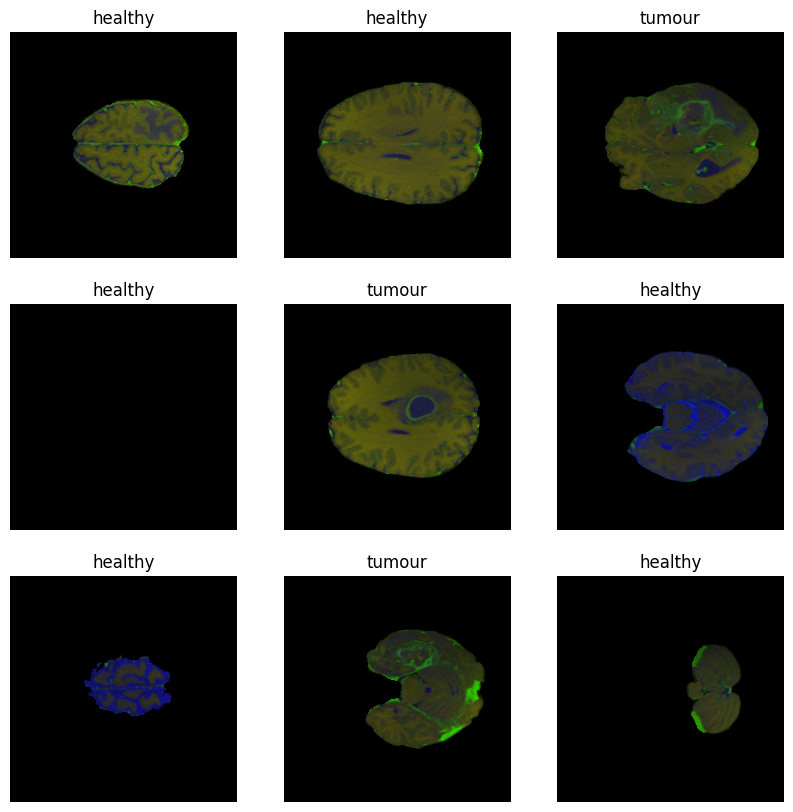

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 3)
(32,)


In [17]:
IMG_SIZE = (224, 224)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [21]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

ValueError: Input 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 240, 240, 3)

In [22]:
base_model.trainable = False

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

NameError: name 'feature_batch' is not defined

In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

NameError: name 'feature_batch_average' is not defined

In [26]:
cropping = tf.keras.layers.Cropping2D(8)
image_batch, label_batch = next(iter(train_ds))
output_batch = cropping(image_batch)
print(output_batch.shape)

(32, 224, 224, 3)


In [27]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = cropping(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

2022-11-23 15:02:21.420203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 6s 169ms/step - loss: 0.5991 - accuracy: 0.7452


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.60
initial accuracy: 0.75


In [32]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


2022-11-23 15:04:53.237316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 22s 212ms/step - loss: 0.6319 - accuracy: 0.7690 - val_loss: 0.4858 - val_accuracy: 0.7661
Epoch 2/10
78/78 [==============================] - 14s 183ms/step - loss: 0.5553 - accuracy: 0.7730 - val_loss: 0.4439 - val_accuracy: 0.7661
Epoch 3/10
78/78 [==============================] - 14s 185ms/step - loss: 0.5137 - accuracy: 0.7754 - val_loss: 0.4208 - val_accuracy: 0.7661
Epoch 4/10
78/78 [==============================] - 14s 186ms/step - loss: 0.4822 - accuracy: 0.7786 - val_loss: 0.4044 - val_accuracy: 0.7758
Epoch 5/10
78/78 [==============================] - 14s 186ms/step - loss: 0.4569 - accuracy: 0.7823 - val_loss: 0.3786 - val_accuracy: 0.7806
Epoch 6/10
78/78 [==============================] - 14s 182ms/step - loss: 0.4346 - accuracy: 0.7895 - val_loss: 0.3719 - val_accuracy: 0.7839
Epoch 7/10
78/78 [==============================] - 14s 184ms/step - loss: 0.4154 - accuracy: 0.7931 - val_loss: 0.3558 - val_accuracy: 0.7935
Epoch 8/10

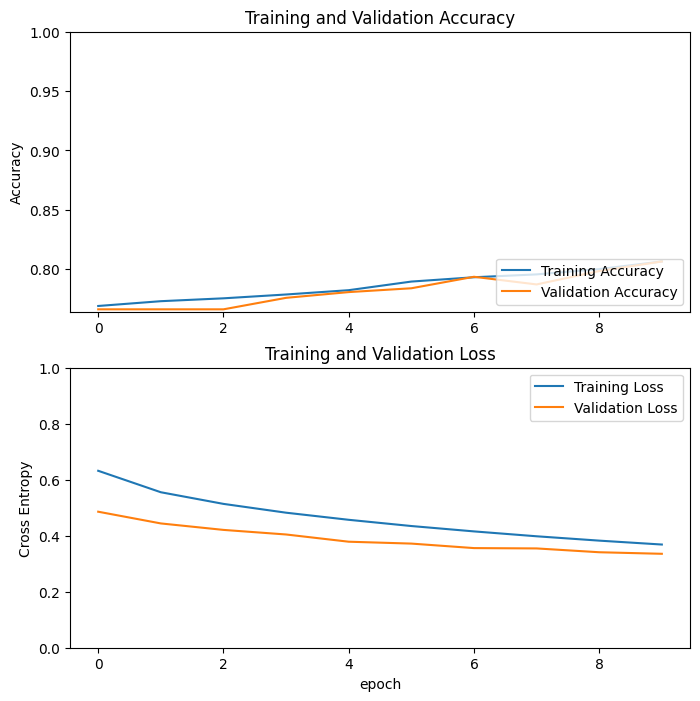

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
base_model.trainable = True

In [35]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [38]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/30


2022-11-23 15:16:38.259623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8448

2022-11-23 15:17:03.096871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 32s 296ms/step - loss: 0.3074 - accuracy: 0.8448 - val_loss: 0.2592 - val_accuracy: 0.9274
Epoch 11/30
78/78 [==============================] - 19s 247ms/step - loss: 0.2168 - accuracy: 0.8996 - val_loss: 0.2240 - val_accuracy: 0.8694
Epoch 12/30
78/78 [==============================] - 19s 243ms/step - loss: 0.1687 - accuracy: 0.9294 - val_loss: 0.1485 - val_accuracy: 0.9371
Epoch 13/30
78/78 [==============================] - 19s 246ms/step - loss: 0.1316 - accuracy: 0.9440 - val_loss: 0.1343 - val_accuracy: 0.9387
Epoch 14/30
78/78 [==============================] - 19s 248ms/step - loss: 0.1057 - accuracy: 0.9585 - val_loss: 0.0983 - val_accuracy: 0.9645
Epoch 15/30
78/78 [==============================] - 19s 242ms/step - loss: 0.0836 - accuracy: 0.9690 - val_loss: 0.1303 - val_accuracy: 0.9661
Epoch 16/30
78/78 [==============================] - 20s 251ms/step - loss: 0.0638 - accuracy: 0.9762 - val_loss: 0.1051 - val_accuracy: 0.9645
Epoc

In [40]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True)

"dot" with args ['-Tpng', '/var/folders/6l/vz3vtlzd3db4p7t7h5t2rd040000gn/T/tmpzmbdifix'] returned code: 1

stdout, stderr:
 b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x99\x00\x00\x03C\x08\x06\x00\x00\x00\xe6}\x04\xaf\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xdd{TT\xf5\xfe?\xfe\xe7\x80\x808r\x93\xa3\x88\xa2B^0%\x03E\x13\xa5\xbc\x1d\xf1z\xbc\x84H\x02\xa1\xe1\x89P\xf1h|QD2*%\xbc\x9c\x94\x16\xd2\xd1\x10\x81\xce\xf1\x82\x82"\xea\xd1\xc0\xf31#\xf1\x92RaZ\x8a\x80\x82\x8a\x88\x85\xa0 \xe30\xf3\xfa\xfd\xc1\x9a\xfds\x9cAn\x833\x8c\xaf\xc7Z\xac\xd5\xbc\xf7{\xef\xfd\xda\xfb=\xc8\xab\xbd\xdf\x17\x11\x11\x11\x18c\x8c1\xc6\x18\xd3 \x03m\x07\xc0\x18c\x8c1\xc6\xf4\x0f\'\x99\x8c1\xc6\x18cL\xe38\xc9d\x8c1\xc6\x18c\x1a\xc7I&c\x8c1\xc6\x18\xd3\xb8\x0e\xda\x0e\x80i\x96\x97\x97\x97\xb6C`\x8c1\xc6Z$$$\x04nnn\xda\x0e\x83i\x08?\xc9\xd43\xa9\xa9\xa9\xb8u\xeb\x96\xb6\xc3hW\xce\x9e=\x8b\xb3g\xcfj;\x0c\xa6\x06\x7f\x9f\x1b\xc7\xdf_\xa6/RSSQRR\xa2\xed0\x98\x06\xf1\

AssertionError: "dot" with args ['-Tpng', '/var/folders/6l/vz3vtlzd3db4p7t7h5t2rd040000gn/T/tmpzmbdifix'] returned code: 1